## Basic config, package loading

In [1]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
from torch import Tensor
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet

In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

## Model selection

In [9]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr

#unet_name = 'monai-64-4-4'
unet_name = 'swinunetr'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()


## Everything Data

In [8]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = True


# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A', 'B', 'C', 'D']


In [6]:
## Sanity Check if config is as expected
print(OmegaConf.to_yaml(cfg))

debug: true
wandb:
  log: true
  project: MICCAI2023-extension
fs:
  root: ../../
data:
  brain:
    data_path: data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/
  heart:
    data_path: data/mnm/
unet:
  brain:
    pre: calgary_unet
    n_chans_in: 1
    n_filters_init: 8
    n_chans_out: 1
    training:
      save_loc: pre-trained
      train_site: 6
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      epochs: 250
      patience: 4
      lr: 0.001
  heart:
    pre: swinunetr
    n_chans_in: 1
    n_filters_init: null
    n_chans_out: 4
    training:
      save_loc: pre-trained
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      num_val_batches_per_epoch: 50
      epochs: 250
      patience: 4
      lr: 0.001
    arch: swinunetr
run:
  iteration: 0
  data_key: heart
eval:
  data:
    training: true
    validation: true
    testing: all
    subset:
      apply: true
      

## General Eval Pipeline

In [10]:

#####################################################
### From eval.unet_test. Modify to fit your needs ###
#####################################################

from typing import Dict
from omegaconf import OmegaConf
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from utils import  epoch_average
from losses import (
    DiceScoreCalgary, 
    DiceScoreMMS
)



def get_df_from_dict(
    cfg: OmegaConf,
    metrics: Dict
):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key

    return df


def eval_set(
    cfg: OmegaConf,
    model: nn.Module,
    dataset: Dataset
) -> Dict:
    if cfg.run.data_key == 'brain':
        dataset.volume_wise = True
        dataloader = DataLoader(
            dataset,
            batch_size=32,
            shuffle=False,
            drop_last=False
        )
        eval_metrics = {
            'Volumetric Dice': DiceScoreCalgary(),
            # Surface Dice is not defined for fragmented volumes, which we get
            # by subsetting above. The original eval function in
            # eval.unet_test does support surface Dice but not subsetting.
            # 'Surface Dice': SurfaceDiceCalgary() 
        }
        metrics = eval_brain_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )

    elif cfg.run.data_key == 'heart':
        dataloader = DataLoader(dataset, 
            batch_size=32, 
            shuffle=False, 
            drop_last=False
        )
        eval_metrics = {
            "Volumetric Dice": DiceScoreMMS()
        }
        metrics = eval_heart_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )
    
    else:
        raise ValueError(
            f'Invalid data key. No dataset named {cfg.run.data_key}'
        )

    return metrics



@torch.no_grad()
def eval_brain_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    batch_sizes = []
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        net_out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(metric(net_out,target).detach().mean().cpu())

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)

    return epoch_metrics



@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    # saves batch sizes for each batch for averaging
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].cuda()
        # convert -1 labels to background
        target[target == -1] = 0
        # convert to one-hot encoding
        target = F.one_hot(
            target.long(), 
            num_classes=4
        ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out = model(input_.cuda())
        
        batch_sizes.append(input_.shape[0])
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(
                metric(net_out, target).detach().mean().cpu()
            )
            
    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
    return epoch_metrics

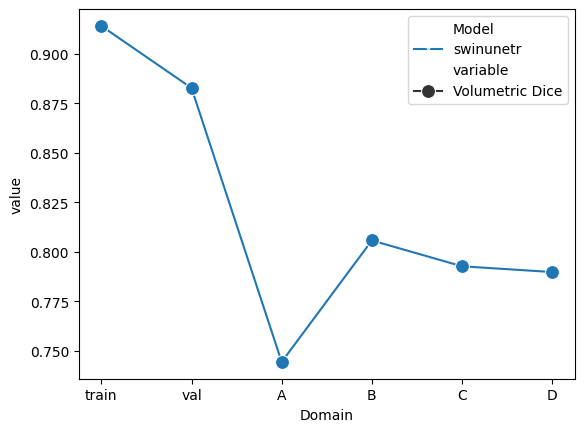

In [11]:
metrics = {}

for key in data.keys():
    metrics[key] = eval_set(
        cfg=cfg,
        model=unet,
        dataset=data[key]
    )

df = get_df_from_dict(cfg, metrics)

sns.lineplot(
    data=df, 
    x='Domain', 
    y='value', 
    hue='Model',
    style='variable',
    markers=True, 
    dashes=False, 
    markersize=10, 
    marker='x'
)
plt.show()

## Image selection and analysis

In [12]:
# select single image
print(f'\nAvailable datasets are:')
for key in data:
    print(f'  {key}: {len(data[key])} images')


domain = 'val'
idx    = 20
image, seg_mask, voxel_spacing = data[domain][idx].values()


Available datasets are:
  train: 50 images
  val: 50 images
  A: 50 images
  B: 50 images
  C: 50 images
  D: 50 images


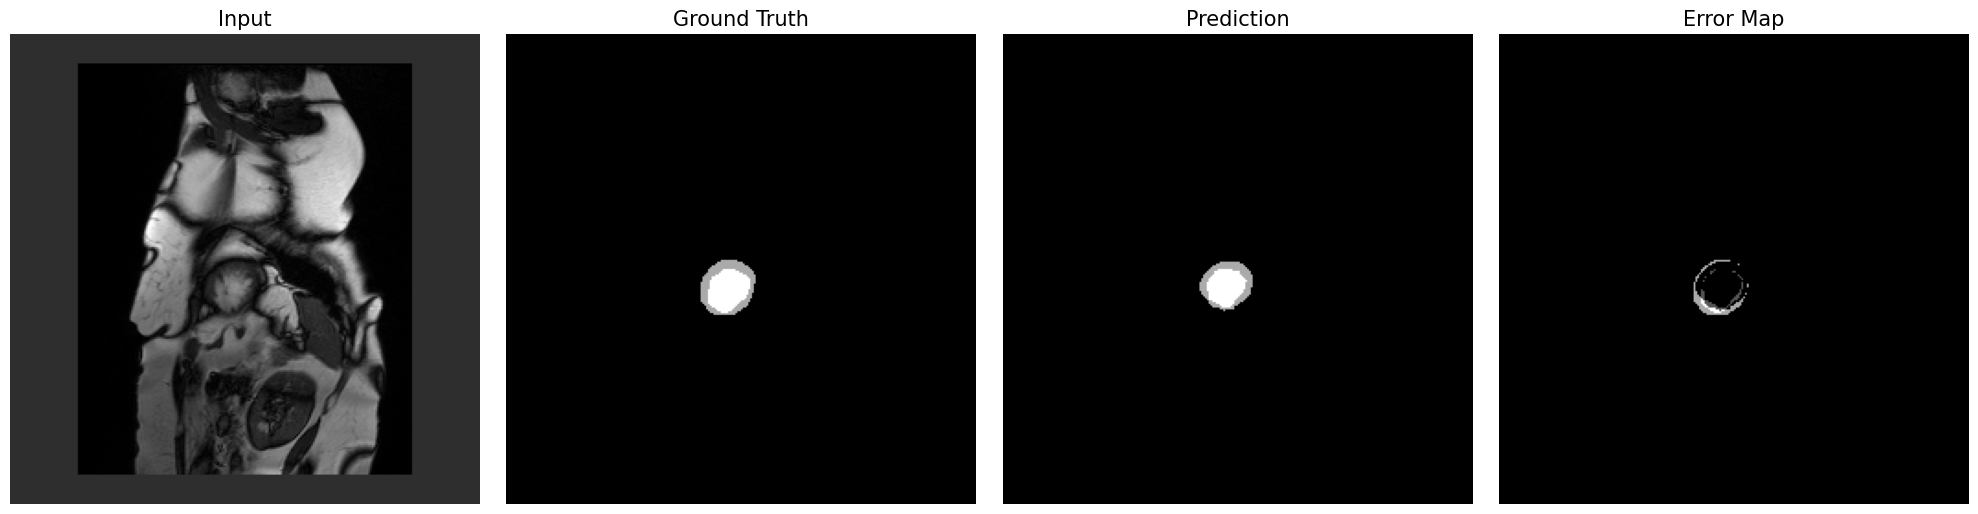

In [13]:
# segment image
with torch.no_grad():
    net_out = unet(image.unsqueeze(0).cuda()).detach().cpu()
    if DATA_KEY == 'brain':
        prediction = (net_out[0] > 0.5) * 1
    elif DATA_KEY == 'heart':
        prediction = net_out.argmax(1)
    error_map = (seg_mask - prediction).abs()


# plot results
def plot_side_by_side(
    images: List[Tensor], 
    titles: List[str] = None, 
    cmap: str = 'gray'
):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))
    
    if n == 1:  # If only one image, wrap axes in a list to make iterable
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i], fontsize=15)
        
    plt.tight_layout()
    return fig


fig = plot_side_by_side(
    images = [
        image[0], 
        seg_mask[0], 
        prediction[0], 
        error_map[0],
    ], 
    titles = [
        'Input', 
        'Ground Truth', 
        'Prediction',
        'Error Map',
    ]  # comment to hide titles
)